# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection Project** 
***
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Importing Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time

from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# displaying the images on the jupyter notebook
%matplotlib inline 


## Original image

In this project we will apply a series of transformation to the image, we will therefore start by displaying the original image

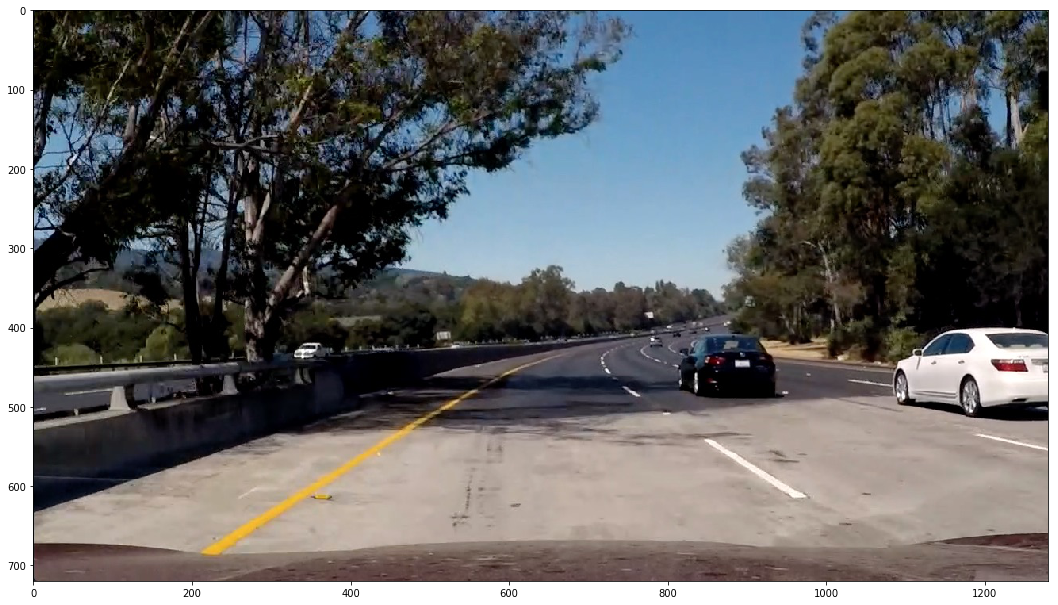

In [2]:
#reading in an image
original_image = mpimg.imread('test_images/test5.jpg')

# print('This image is:', type(original_image), 'with dimensions:', original_image.shape)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(original_image)

## Dataset exploration

Let us load our dataset and start with some remarks regarding it:
1. The car images are 64x64 png colored images
2. Contrary to the traffic signs panels dataset the images of the cars are clear. Indeed, a human being can clearly identify that the images are representing cars. While this dataset does not contain unclear images, it contains an awful lot of duplicates (same car with a slight different lightining/angle) because the dataset have been generated from a time serie data. If we just take the dataset as is and just split it randomly into a training/cross-validation and test set, we will have a lot of images that will be shared between the datasets. The result will be a model that will overfit the data with a good accuracy regarding all the different datasets. In order to avoir this we will manually create our training/validation and test datasets. Since the images are numbered and since the images that represent the same car are following one another we will try to put the same images in the same dataset. Therefore we will partition the data following this rule : 
> *  0 <= image_number % 100 < 75 => training set
> * 85 <= image_number % 100 < 100 => test set


Once we have split the data, we will shuffle it to avoid having an order in our datasets. Morevover, we don;t need to bother working with generators because our the size of our dataset is small ( 300 mb ) and my computer has 16GB ram memory

In [3]:
import glob
from sklearn.model_selection import train_test_split

# handling gti data, that contains time serie data
gti_train = []
gti_test = []
gti_images = glob.glob('dataset/vehicles/G*/*.png')
for gti_image in gti_images:
    image_path = gti_image.split("/")
    image_filename = image_path[-1]
    image_number = int(image_filename.replace("image", "").replace(".png",""))
    q,r = divmod(image_number, 250)
    if 0 <= r and r < 184 :
        gti_train.append(gti_image)
    elif 194 <= r and r <= 240 :
        gti_test.append(gti_image)

print(len(gti_train))
print(len(gti_test))

# handling kitti, doesn't contain time serie data
kitti_car_images = glob.glob('dataset/vehicles/KITTI*/*.png')
kitti_vehicles = []
for kitti_car_image in kitti_car_images:
    kitti_vehicles.append(kitti_car_image)
    
rand_state = np.random.randint(0, 100)
kitti_car_train, kitti_car_test, _1, _2 = train_test_split(kitti_vehicles, [1]*len(kitti_vehicles), test_size=0.2, random_state=rand_state)

print(len(kitti_car_train))
print(len(kitti_car_test))

# The shuffling here doesn't bring anything since we are shuffling at the end. I am shuffling the data here because
# I will take a subset of this set to benchmark the get_hog_function
car_train = shuffle(np.concatenate((gti_train, kitti_car_train)))
car_test = shuffle(np.concatenate((gti_test, kitti_car_test)))

# Handling not car image, doesn't contain timeserie data
not_car_images = glob.glob('dataset/non-vehicles/*/*.png')
not_vehicles = []
for not_car_image in not_car_images:
    not_vehicles.append(not_car_image)
    
rand_state = np.random.randint(0, 100)
not_car_train, not_car_test, _1, _2 = train_test_split(not_vehicles, [0]*len(not_vehicles), test_size=0.2, random_state=rand_state)

print(len(not_car_train))
print(len(not_car_test))

# Concatenating and shuffling

X_train = np.concatenate((car_train, not_car_train))
Y_train = np.concatenate( ([1]*len(car_train), [0]*len(not_car_train)) )

X_test = np.concatenate((car_test, not_car_test))
Y_test = np.concatenate( ([1]*len(car_test), [0]*len(not_car_test)) )

X_train, Y_train = shuffle(X_train, Y_train)
X_test, Y_test = shuffle(X_test, Y_test)

print(len(X_train))
print(len(Y_train))
print(len(X_train))
print(len(Y_test))


2084
522
4772
1194
7174
1794
14030
14030
14030
3510


## Histogram of Oriented Gradients (HOG)

In this section we will take the images of our dataset as an input and apply to them the hog transform. The output of the HOG transform will then be fed to our machine learning pipeline as features to train our classifier.
In order to apply the HOG transform to an image, several parameters should be set (color space, orientations, pixels_per_cell, cells_per_block). In order to know which parameters work best we will test them with our machine learning algorithm. We will therefore pick the settings that achieve the best accuracy 

### Defining the get_hog function

In this section we will just define a get_hog_features. This function will then be benchmarked in the following section in order to extract the best parameters. We will then fix these parameters and train our machine learning model using the dataset that we build in the previous section

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Benchmarking the get_hog_features

In this section we will set up a a training pipeline to benchmark the get_hog_features in order to select the best parameters

In [ ]:
# Definition of the training and test datasets

SAMPLE_SIZE = 2000
benchmark_cars = car_train[0:SAMPLE_SIZE]
benchmark_notcars = not_car_train[0:SAMPLE_SIZE]

# Parameters of the HOG transform that we can tune

COLORSPACE = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
NUMBER_OF_ORIENTATIONS = 12
PIX_PER_CELL = 12
CELL_PER_BLOCK = 2
HOG_CHANEL = "ALL" # Can be 0, 1, 2, or "ALL"


# get feature function
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



t=time.time()
car_features = extract_features(benchmark_cars, cspace=COLORSPACE, orient=NUMBER_OF_ORIENTATIONS, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANEL)
notcar_features = extract_features(benchmark_notcars, cspace=COLORSPACE, orient=NUMBER_OF_ORIENTATIONS, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANEL)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',NUMBER_OF_ORIENTATIONS,'orientations',PIX_PER_CELL,'pixels per cell and',
      CELL_PER_BLOCK,'cells per block in the ', COLORSPACE, 'colorspace', HOG_CHANEL, 'hog chanel')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')




### Benchmarking remarks and conclusion

1. **effect of the number of orientation : ** Increasing the number of orientations considerably increases the learning time and increases the number of features and the extraction time. if we compare extreme values 12 with 40 orientations and keep the other parameters the same. We have an accuracy gain of 0,2 but we multiplied by 6 the training time and by 4 the extraction time. we also multiplied by 3 the number of features. This accuracy gain is not worth it because changing other parameter is more benefic as we will see. We will therefore take **12 orientations** 
2. **effect of the color space : ** When working with the HOG, RGB is no good. Indeed the learning time using the RGB color space is 10 times slower than the learning with the other channels. Moreover the extraction time is 2 times slower than the other channel. (The LUV color space throws an exception, so we will not work with it). HLS, HSC and YUV are approximatevely the same. We will slect the ** YUV channel** because the learning time is lower than the others
3. ** effect of the channels ** : taking all the channels brings 3 times more features than one, but considerably increases the accuracy. We will therefore pick the features from **all the 3 channels**. This statements holds for the RGB color space as for the YUV colorspace
4. ** effect of the pixels per cell ** : increasing the number of pixels per cell considerably decreases the extraction time, the number of features and the training time. This increase also brings a really small decrease in accuracy. 8 px per cell has the best accuracy but bings more features thus slows the training time. We will therefore pick ** 12 or 16 pixel ** per cell because they decreasing the learning and extraction time without impacting the accuracy that much
5. ** effect of the cell per block** : increasing the number of cells per bloc increases the number of features. keeps the the extraction time the same and increases the precision up to a certain point and then decreases the accuracy. The best **value is 2** in our case

**Conclusion** :
> * COLORSPACE = 'YUV' 
> * NUMBER_OF_ORIENTATIONS = 12
> * PIX_PER_CELL = 12
> * CELL_PER_BLOCK = 2
> * HOG_CHANEL = "ALL"


### Example of our hog transform

let's us transform one car image and one non car image of our dataset


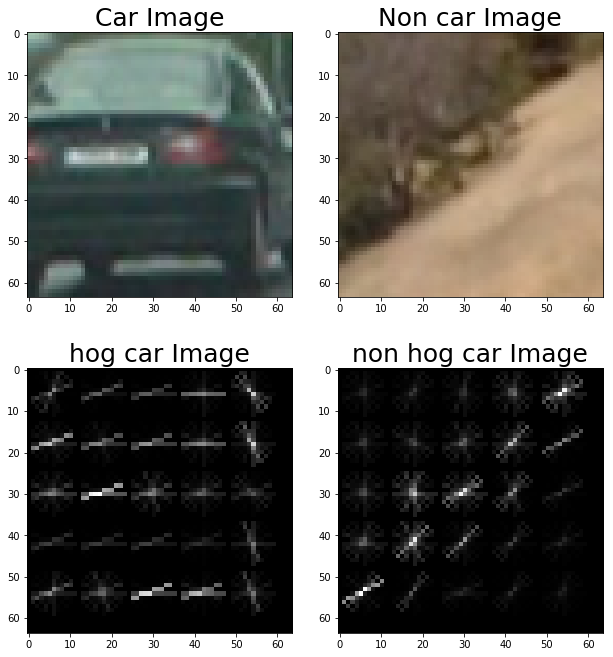

In [31]:
car_image = mpimg.imread(car_train[0])
car_image_yuv = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
_, hog_car_y = get_hog_features(car_image_yuv[:,:,0], 12, 12, 2, vis=True, feature_vec=True)

non_car_image = mpimg.imread(not_car_train[0])
not_car_image_yuv = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2YUV)
_, hog_not_car_y = get_hog_features(not_car_image_yuv[:,:,0], 12, 12, 2, vis=True, feature_vec=True)


f, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 8))
f.tight_layout()
ax1[0].imshow(car_image)
ax1[0].set_title('Car Image', fontsize=25)
ax1[1].imshow(non_car_image)
ax1[1].set_title('Non car Image', fontsize=25)
ax2[0].imshow(hog_car_y, cmap='gray')
ax2[0].set_title('hog car Image', fontsize=25)
ax2[1].imshow(hog_not_car_y, cmap='gray')
ax2[1].set_title('non hog car Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

### Extracting color and spatial features

To the hog features we will add the following features:
1. Color channel histograms : We represent in the form of histograms the number of pixels in function of their intensity in the R, G, B color space. The goal of these features will be to detect if an image holds the colors of the cars. These features only rely on the color of the image. 
2. raw pixels values :  the features consist of the raw pixels of the car after processing the image with a spatial binning. We do that to reduce the noise and because the full resolution does not provide more information to classify an image into a car or non car. When ploting the distribution of the color pixels in the HSV referential we can better clusterize the pixels that belong to the car than in the RGB color space. Therefore we will use the HSV refetial for these features. 

Let us now write these functions

In [9]:
# WE FEED RGB IMAGES TO THESE FUNCTIONS

def bin_spatial(img, size=(32, 32)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Training pipeline

We extract three different types of features, each feature takes its value from a a different range of values. Because these range of values do not have the same order of magnitude we will use a per column scaler to avoid having a feature that is ridiculously small in front of another.
For this project we will use and SVM classifier with linear kernels


In [10]:
COLORSPACE = 'YUV' 
NUMBER_OF_ORIENTATIONS = 12
PIX_PER_CELL = 12
CELL_PER_BLOCK = 2
HOG_CHANEL = "ALL"

# get feature function
def extract_features(imgs, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:

        image = mpimg.imread(file)
        
        if np.amax(image) > 1:
            image = image.astype(np.float32)/255
        
        # apply 'YUV' color conversion for the hog transform
        yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        for channel in range(yuv_image.shape[2]):
            hog_features.append(get_hog_features(yuv_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features) 
        
        # Get color features
        spatial_features = bin_spatial(image, size=(32,32))
        hist_features = color_hist(image, nbins=32)

        # Scale features and make a prediction
        extracted_features = np.hstack((spatial_features, hist_features, hog_features))
            
        # Append the new feature vector to the features list
        features.append(extracted_features)

    # Return list of feature vectors
    return features



# Training set
t=time.time()
X = extract_features(X_train, orient=NUMBER_OF_ORIENTATIONS, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANEL)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features for the training dataset...')


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X_train = X_scaler.transform(X)

# X test
t=time.time()
X = extract_features(X_test, orient=NUMBER_OF_ORIENTATIONS, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANEL)
# we apply the same scaler !
scaled_X_test = X_scaler.transform(X)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features for the test dataset...')


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(scaled_X_train, Y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, Y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(scaled_X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', Y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/Shaka/anaconda/envs/car_degree/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


187.97 Seconds to extract HOG features for the training dataset...
47.97 Seconds to extract HOG features for the test dataset...
5.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9855
My SVC predicts:  [0 0 0 0 0 0 0 0 0 1]
For these 10 labels:  [0 0 0 0 0 0 0 0 0 1]
0.00105 Seconds to predict 10 labels with SVC


### Sliding Window Search

We have a model that classifies a 64x64 image into a car or a non car, we need to apply this model to an image captured by the camera located in the middle of the car.
In order to do that we will use sliding windows. We will compute the hog transform of the bottom half of the image, then will slide a bounding box and see if the image inside the bounding box is a car or not. To improve our result of the search we have 2 parameters to adjust:
1. The size of the bounding box
2. The step at which we move the bounding box (in term of hog cells)

Depending of their position from the camera, the cars will not have the same size. The closer to the camera they are, the bigger they will appear. To capture that we will take use the sliding window search with 3 different size (64x64, 96x96 and 128x128). We will use opencv to fit these bounding boxes to 64x64 bounding boxes.

The step is also an important factor, indeed the more steps we take, the more car detections and false positive we will have. Using a small step works better, provided that you can filter false positives. We will therefore take a step of one block and build a component in our pipeline that will filter the false positives. therefore the goal of the find_cars function will be to output an array of bounding boxes

In [21]:
original_image = mpimg.imread('test_images/testbig.jpg')

Y_START = original_image.shape[0]//2
Y_STOP = original_image.shape[0]
COLORSPACE = 'YUV' 
NUMBER_OF_ORIENTATIONS = 12
PIX_PER_CELL = 12
CELL_PER_BLOCK = 2
HOG_CHANEL = "ALL"


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler):
    
    bbox_list = []
    draw_img = np.copy(img)
    if np.amax(img) > 1:
        img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
     
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // PIX_PER_CELL) - CELL_PER_BLOCK + 1
    nyblocks = (ch1.shape[0] // PIX_PER_CELL) - CELL_PER_BLOCK + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // PIX_PER_CELL) - CELL_PER_BLOCK + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, NUMBER_OF_ORIENTATIONS, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    hog2 = get_hog_features(ch2, NUMBER_OF_ORIENTATIONS, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    hog3 = get_hog_features(ch3, NUMBER_OF_ORIENTATIONS, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*PIX_PER_CELL
            ytop = ypos*PIX_PER_CELL

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=(32,32))
            hist_features = color_hist(subimg, nbins=32)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # In case you want to draw on the image           
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                # In case you want to provided the list of bounding boxes
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list # bbox_list draw_img
    

# bbox_result = find_cars(original_image, ystart, ystop, scale, svc, X_scaler)


# # Plotting the result, be sure to uncomment and comment the appropriate lines in draw_car function
# ystart = Y_START
# ystop = Y_STOP

# scale1 = find_cars(original_image, ystart, ystop, 1, svc, X_scaler)
# scale16 = find_cars(original_image, ystart, ystop, 1.6, svc, X_scaler)
# scale2 = find_cars(original_image, ystart, ystop, 2, svc, X_scaler)

# f, ax = plt.subplots(3, 1, figsize=(36, 12))
# f.tight_layout()
# ax[0].imshow(scale1)
# ax[0].set_title('scale = 1', fontsize=25)
# ax[1].imshow(scale16)
# ax[1].set_title('scale = 1.6', fontsize=25)
# ax[2].imshow(scale2)
# ax[2].set_title('scale = 2', fontsize=25)
# plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0.)


### Filtering false positives and extracting one bounding box per car

From the bounding boxes that were classified as car, let us build a heatmap (every bouding box will add 1 to the pixels it contains). We will apply a treshold on the heatmap to filter false positives and add a bounding box on the resulting heatmap to output the car detected in the image

In [34]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test2.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def draw_cars(img, bbox_list, treshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox_list)
    heat = apply_threshold(heat, treshold)
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # drawing the boxes on the car    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

THE CELL BELOW IS ONLY USED TO DRAW THE RESULTS AT DIFFERENT STAGES OF THE PIPELINE

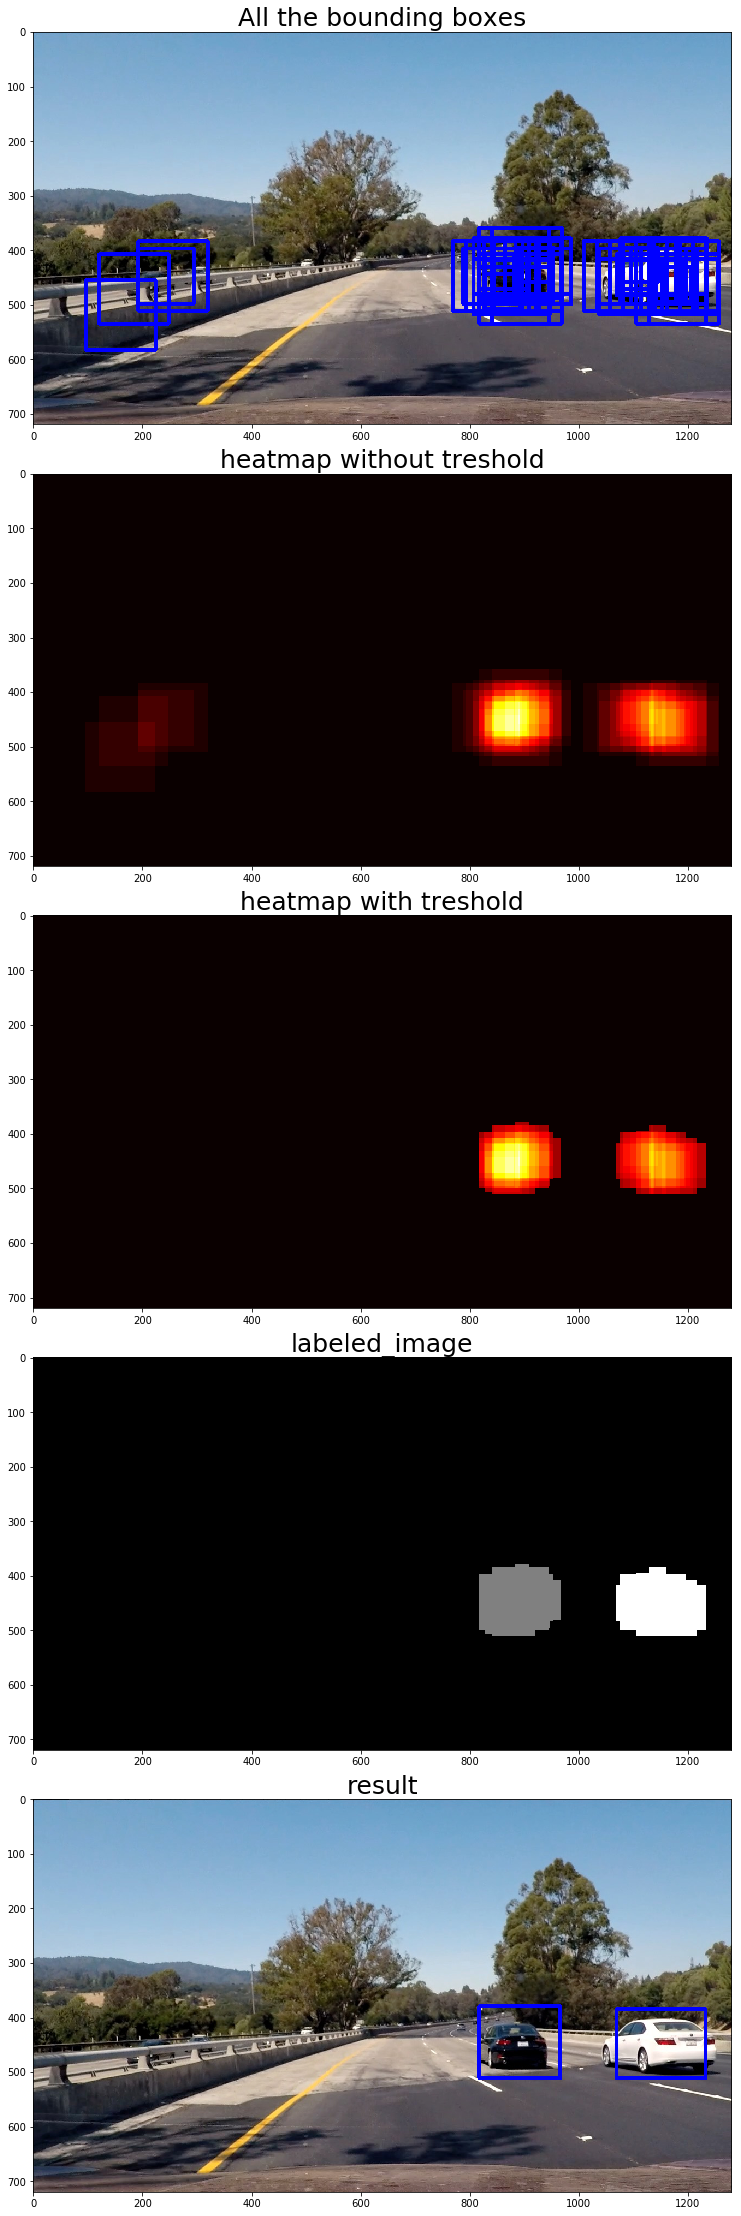

In [46]:
# Vizualisation ONLY

image = mpimg.imread('test_images/test4.jpg')
scales = [1, 1.6, 2]
Y_START = original_image.shape[0]//2
Y_STOP = original_image.shape[0]

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

def draw_cars_vizu(img, bbox_list, treshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox_list)
    no_treshold_heatmap = np.clip(heat, 0, 255)
    heat = apply_threshold(heat, treshold)
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # drawing the boxes on the car    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img,no_treshold_heatmap, heatmap, labels[0]

def frame_cars_in_image_vizu(image, ystart, ystop, scales, svc, X_scaler, treshold):
    bbox_list = []
    for scale in scales:
        scale_bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler)
        for bbox in scale_bbox_list:
            bbox_list.append(bbox)
            
    bboxed = draw_boxes(image, bbox_list)
    result, no_treshold, heatmap, labeled_image = draw_cars_vizu(image, bbox_list, treshold)
    return result, bboxed, no_treshold, heatmap, labeled_image


result, bboxed, no_treshold, heatmap, labeled_image = frame_cars_in_image_vizu(image, Y_START, Y_STOP, scales, svc, X_scaler, 6)



f, ax = plt.subplots(5, 1, figsize=(100, 20))
f.tight_layout()
ax[0].imshow(bboxed)
ax[0].set_title('All the bounding boxes', fontsize=25)
ax[1].imshow(no_treshold, cmap='hot')
ax[1].set_title('heatmap without treshold', fontsize=25)
ax[2].imshow(heatmap, cmap='hot')
ax[2].set_title('heatmap with treshold', fontsize=25)
ax[3].imshow(labeled_image, cmap='gray')
ax[3].set_title('labeled_image', fontsize=25)
ax[4].imshow(result)
ax[4].set_title('result', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0.)



# VIZU

### Complete pipeline

Let us now combine the functions we have built and build a pipeline that frame the cars in an image

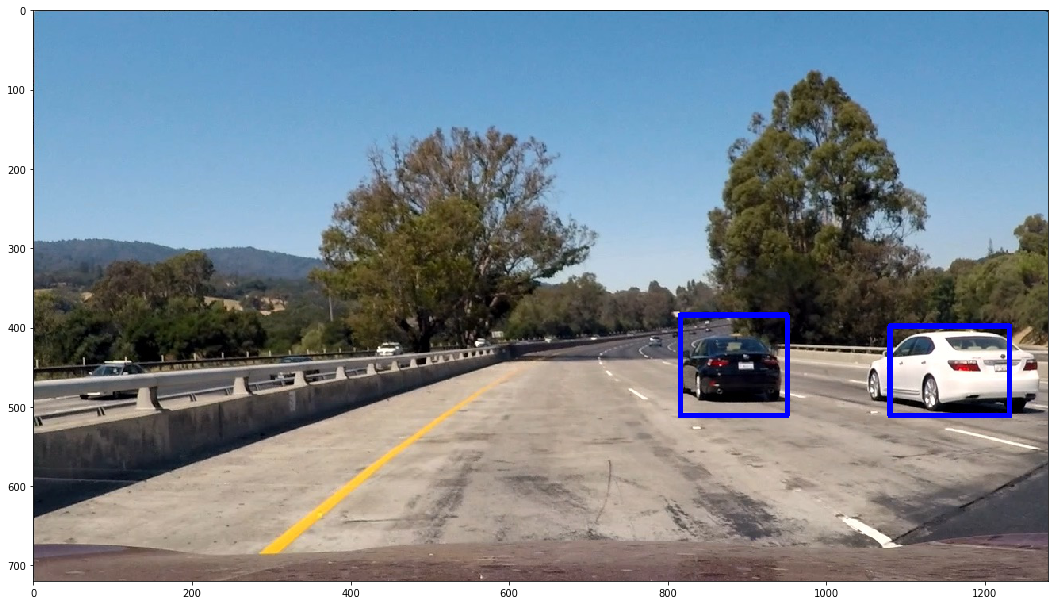

In [49]:
image = mpimg.imread('test_images/test1.jpg')
scales = [1, 1.6, 2]
Y_START = original_image.shape[0]//2
Y_STOP = original_image.shape[0]

def frame_cars_in_image(image, ystart, ystop, scales, svc, X_scaler, treshold):
    bbox_list = []
    for scale in scales:
        scale_bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler)
        for bbox in scale_bbox_list:
            bbox_list.append(bbox)
        
    result = draw_cars(image, bbox_list, treshold)
    return result

framed_image = frame_cars_in_image(image, Y_START, Y_STOP, scales, svc, X_scaler, 10)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(framed_image)



## Test on Videos

We can test now our solution on the provided video

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
output_video = './project_video_result_final.mp4'

clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(lambda image : frame_cars_in_image(image, Y_START, Y_STOP, scales, svc, X_scaler, 8))
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_result_final.mp4
[MoviePy] Writing video ./project_video_result_final.mp4



 12%|█▏        | 147/1261 [09:22<1:11:12,  3.84s/it]


 23%|██▎       | 293/1261 [18:43<1:01:29,  3.81s/it]


 35%|███▌      | 442/1261 [28:26<54:07,  3.97s/it]


 47%|████▋     | 593/1261 [37:45<42:47,  3.84s/it]


 59%|█████▉    | 744/1261 [47:06<30:50,  3.58s/it]


 71%|███████   | 895/1261 [56:21<21:36,  3.54s/it]


 83%|████████▎ | 1042/1261 [1:05:33<14:00,  3.84s/it]


 94%|█████████▍| 1185/1261 [1:14:30<04:35,  3.62s/it]


100%|█████████▉| 1260/1261 [1:18:57<00:03,  3.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result_final.mp4 

CPU times: user 1h 16min 57s, sys: 1min 50s, total: 1h 18min 48s
Wall time: 1h 18min 58s
